# Table of contents
1. [Motivation](#Motivation)
2. [Global Patterns](#Global)
    1. [Global data](#globaldata)
    2. [Preprocessing and data mining](#preprocessing)
    3. [Basic stats and exploration of the data](#basicstats)
    4. [Data analysis](#dataanalysis)
    5. [Prediction of deaths caused by pollution](#prediction)
    6. [Conclusion](#conclusionglobal)
3. [Zooming in on Denmark](#denmark)
    1. [Data used in the Danish part](#denmarkdata)
    2. [Preprocessing and data mining](#denmarkpre)
    3. [Basic stats - Denmark](#statsdk)
    4. [Data analysis](#analysisdk)
    4. [Conclusion](#conclusiondk)
4. [Genre](#genre)
5. [Visualizations](#visualisations)
6. [Discussion and Conclusion](#finalcon)
7. [Contributions](#contributions)
8. [References](#references)

This notebook is heavy, and even though we have saved it with all visualizations shown, they migh not be visible when you open the notebook. If this is the case, you can run the cells below the text stating **RUN CELL BELOW TO SEE THE VISUALIZATION** instead of running the whole notebook.  

You can access our website about the project [here](https://kvantropologsofie.github.io/socialdata2022.io/docs/pollution-DK/mapping-pollution/mapping_pollution/)

# Understanding consequences of air pollution 

## 1. Motivation <br>  <a name="Motivation"></a>

The quality of the air around us have a significant effect on our daily life and health. Nevertheless, estimates reveal that 99% of the world's population live in areas exceeding WHO's guidelines for clean air. Exposure to air pollution is the fifth greatest risk factor of mortality globally, and every year 4.2 milion people die prematurely from outdoor air pollution (https://www.who.int/data/gho/data/themes/air-pollution/ambient-air-pollution). The exsisting research indicates that individuals with lower socioeconomic status are disproportionally affected by air pollution. Thus, air pollution is a social issue that needs to be elucidated in order to prevent environmental inequality and protect the public health in the future.

Throughout this project we aim to investigate and shed light on differences in exposure to air pollution. Who are affected by the higest concentrations globally, and is it through visualizations possible to detect environmental inequality? In addition to investigating patterns globally, we are also zooming in on Denmark to obtain a more nuanced and unbiased understanding of possible patterns and differenses within a country. 

Through this report we will mainly focus on pollution caused by $PM_{2.5}$, also known as fine inhalable particles. $PM_{2.5}$ is the pollutant causing the greatest risk for human health by causing cardiovascular and respiratory disease, and cancers. $PM_{2.5}$ is emitted from power plants, industries, and automobiles, and are thereby direct consequences of human behaviour. WHO's guidelines are stating that annual average concentrations of $PM_{2.5}$ should not exceed 5 µg/m3. The thresholds for all types of pollution can be found in the following figure:

|  $NO_{2}$| $PM_{2.5}$ | $PM_{10}$|
| --- | --- | --- |
| 10 μg/m3 annual mean | 5 μg/m3 annual mean | 15 μg/m3 annual mean |



The project is thus devided into two parts. First a part where we examine the global development in air pollution over time and investigate whether air pollution is distributed unequally. Second a part where we zoom in on Denmark to investigate patterns in a country with high GDP and relatively low concentrations of air pollution. Throughout both parts of the project we will apply different types of visualizations to explore social differences in the exposure to air pollution. The project provides insights into environmental inequality, but also that it is necessary to investigate each country on a more granular level instead of as a whole unit, as there can be significant social differences even within small geographical differences. Thus, nuanced exploration is key when understanding consequences of global  problems such as air pollution - and in this process proper visualizations are excellent tools. 

## 2. Global Patterns  <a name="Global"></a>

### 2.1 Data
<a name="globaldata"></a>

In this section we are importing the relevant datasets, preprocessing them and combining them to create our final dataset for the global part of the project. The dataset will contain features describing the annual concentrations of $PM_{2.5}$, death rates related to pollution and features related to the economy and health of all countries. The final dataset consists of observations from 2011 to 2017. 

**WHO**

The pollution data used in the analysis is retrieved from WHO and contains concentrations of ambient air pollution for almost all countries globally (https://www.who.int/data/gho/data/indicators/indicator-details/GHO/concentrations-of-fine-particulate-matter-(pm2-5)). The dataset is only covering one type of pollution, $PM_{2.5}$, which will be our main pollutant throughout all parts of the project. 

**Our world in data**

We are further retrieving a range of datasets from *Our World in Data* regarding death rates related to the exposure of $PM_{2.5}$, the cardiovascular disease death rate, and the health expenditure as % of GDP. All datasets from OWID originates from WHO. Death rates are measured by the number of deaths per 100.000 individuals in a given country. 

**The World Bank**

We are further enriching the data with GDP data from the World Bank in order to investigate whether cointries with lower GDP are experiencing higher concentrations of air pollution.  

In [6]:
### Importing modules for Part A
#Import modules for data processing 
import pandas as pd
import pycountry # To import pycountry you have to run "pip install pycountry" in your prompt
import json
import re
import requests

# Import modules for interactive vizualizations  
from bokeh.io import push_notebook, show, output_notebook,reset_output,curdoc
from bokeh.layouts import row,layout 
from bokeh.plotting import figure,output_file, save
from bokeh.transform import factor_cmap
from bokeh.models import  ColumnDataSource, Legend,HoverTool,LinearInterpolator
from bokeh.models.widgets import Tabs, Panel
import folium
from folium import plugins
from chart_studio import plotly  # To import plotly you have to run "pip install plotly" in your prompt
import plotly  
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
output_notebook()

#import modules for data machine learning  
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, explained_variance_score,max_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
from IPython.display import IFrame
warnings.filterwarnings('ignore')

Loading BokehJS ...

### 2.2 Preprocessing and data mining:
<a name="preprocessing"></a>
All of the datasets are combined by their ISO codes. For countries without ISO-codes, we are determining the codes by using the python-package pycountry which makes it possible to convert country-names to other formats. 

In [2]:
#Read dataset from WHO with pollution levels
who = pd.read_excel("https://github.com/KvantropologSofie/SocialData2022DTU/raw/main/WHO-data-global.xlsx")

# Defining the years we are interested in (We have pollution data for these years)
years = [2011,2012,2013,2014,2015,2016,2017]

# We subset the data to only contain data from these years 
who = who[who['Measurement Year'].isin(years)]

# Reading data set containing deaths 
deaths = pd.read_csv('https://raw.githubusercontent.com/KvantropologSofie/SocialData2022DTU/main/deaths_owid.csv') 

#Dropping irrelevant collumns 
deaths = deaths.drop(columns = {'Year.1', 
                                'Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: Age-standardized (Rate).1'})

# Fixing country codes to not have replicates
deaths['Entity'] = deaths['Entity'].replace({'Republic of Vietnam: Vietnam'})

# Removing Abknazia from the list of contries as it is not recognized by the modules we use 
deaths.drop(deaths[deaths.Code =="OWID_ABK"].index, inplace=True)

#Subsetting the dataframe based on years included in the original df:
deaths = deaths[deaths.Year.isin(years)]

#Creating function to getting full name of the countries in the pollutiondf:
def get_full_country(value):
    full_name = pycountry.countries.get(name=value)
    try: 
        name = full_name.alpha_3
    except:
        name = 'NaN'
    return name

#Applying function to get full names of counties:
deaths['Country_iso'] = deaths['Entity'].apply(get_full_country)

#Merging the dfs together based on year and country-name:
df = deaths.merge(who, left_on=['Country_iso', 'Year'], right_on=['ISO3', 'Measurement Year'], how='left')

#Dropping redundant coulmns:
df = df.drop(columns = {'Status', 'Version of the database','PM10 (μg/m3)', 'NO2 (μg/m3)'})

df_agg = df.groupby(['Country_iso', 'Year','Entity'])[['PM2.5 (μg/m3)', 'Population (historical estimates)', 'Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: Age-standardized (Rate)']].mean().reset_index()

# Enriching the data further with data from Our World in Data about pollution
pollution2 = pd.read_csv('https://raw.githubusercontent.com/KvantropologSofie/SocialData2022DTU/main/PM25-air-pollution_owid.csv') 

# Selecting codes in data that we use fir merging
codes = pollution2[['Code', 'Entity']]

#Merging on country codes from pollution data and replacing NaNs
df_agg = df_agg.merge(codes, left_on='Entity', right_on='Entity', how='right')
df_agg['Country_iso'].fillna(df_agg['Code'], inplace = True)

# Merging the rest of the pollution data on 
df_agg = df_agg.merge(pollution2, left_on=['Code', 'Year'], right_on=['Code', 'Year'], how='left')
df_agg['PM2.5 (μg/m3)'].fillna(df_agg['PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)'], inplace = True)

# Removing duplicates 
df_agg['Code'].fillna(df_agg['Country_iso'], inplace = True)
df_agg = df_agg.drop_duplicates()

#Subsetting dataframe based on years:
df_agg = df_agg[df_agg.Year.isin(years)]

# Renaming variable to a shorter name 
df_agg = df_agg.rename(columns = {'Deaths - Cause: All causes - Risk: Outdoor air pollution - OWID - Sex: Both - Age: Age-standardized (Rate)':'Death_rate'})

# defining s asubset containing years, country, population size, country iso, pollution and pollution deaths
final_pol_global = df_agg[['Population (historical estimates)', 'Year', 'Code', 'PM2.5 (μg/m3)', 'Death_rate']]

**Adding GDP to the dataframe**

In the following section we are preprocessing the original data and adding it to our final dataframe.

In [3]:
#Merging on GDP:
gdp = pd.read_excel('https://github.com/KvantropologSofie/SocialData2022DTU/raw/main/gdp.xlsx') 

# Renaming columns 
gdp = gdp.rename(columns={"1990 [YR1990]": 1990,"2000 [YR2000]": 2000, '2011 [YR2011]': 2011, '2012 [YR2012]': 2012, 
                          '2013 [YR2013]': 2013, '2014 [YR2014]': 2014, '2015 [YR2015]': 2015, '2016 [YR2016]': 2016,
                          '2017 [YR2017]': 2017, '2018 [YR2018]': 2018, '2019 [YR2019]': 2019, '2020 [YR2020]': 2020})

# Using pd. melt to transform the year columns to one variable called year
gdp_transformed = pd.melt(gdp, id_vars=["Country Name", "Country Code" ,'Series Name', 'Series Code'], 
                  var_name="Year", value_name="GDP")

# Subsetting the data to only include the years 2011-2017
gdp_transformed = gdp_transformed[gdp_transformed.Year.isin([2011,2012,2013,2014,2015,2016,2017])]

# Dropping irrelevant columns  and duplicates
gdp_transformed = gdp_transformed.drop(columns={'Series Name', 'Series Code'})
gdp_transformed = gdp_transformed.drop_duplicates()

# Removing nans in country code
gdp_transformed = gdp_transformed[gdp_transformed['Country Code'].notna()]

# Merging GDP data to dataframe of pollution and populations 
final_pol_global = final_pol_global.merge(gdp_transformed, left_on=['Code', 'Year'],right_on=['Country Code', 'Year'], how='left')
# Adding NaN where there are no availeble values for GDP
final_pol_global.loc[final_pol_global.GDP == "..","GDP"] = np.nan

**Adding healthcare expenditures and cardiovascular disease rate to dataframe**

In [4]:
# Reading the data sets and removing irrelevant columns
healthcare = pd.read_csv('https://raw.githubusercontent.com/KvantropologSofie/SocialData2022DTU/main/total-healthcare-expenditure-gdp.csv') 
healthcare = healthcare.drop(columns = {'Entity'})
cardi = pd.read_csv('https://raw.githubusercontent.com/KvantropologSofie/SocialData2022DTU/main/cardiovascular-disease-death-rates.csv') 
cardi = cardi.drop(columns = {'Entity'})

# Merging the datasets to the dataset with pollution and gdp
final_pol_global = final_pol_global.merge(healthcare, left_on=['Code', 'Year'], right_on=['Code', 'Year'], how='left')
final_pol_global = final_pol_global.merge(cardi, left_on=['Code', 'Year'], right_on=['Code', 'Year'], how='left')

# Renaming columns to have shorter names 
final_pol_global = final_pol_global.rename(columns={"Population (historical estimates)": "Population","Death_rate":"Air pollution death rate", "GDP": "GDP/capita"})
final_pol_global = final_pol_global.rename(columns={"Indicator:Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%)":"Health expenditure as a % of GDP","Deaths - Cardiovascular diseases - Sex: Both - Age: Age-standardized (Rate)":"Cardiovascular disease death rate","Deaths - Cause: All causes - Risk: Smoking - Sex: Both - Age: Age-standardized (Rate)":"Smoking death rate"})

#Remove Code NaN (from merged data corresponding to not countries)
df_global_clean = final_pol_global[final_pol_global['Code']!='NaN']

#Empty code corresponds to not countries - dropping these
df_global_clean.dropna(subset=['Code'], inplace=True)

#Dropping the grouping of OWID_WRL as this does not correspond to a country
df_global_clean.drop(df_global_clean[df_global_clean.Code=='OWID_WRL'].index, inplace=True)

# Manual check of populations in urban agglomerations of more than 1 million shows missing values to correspond 
# To smaller countries. Thus these missing values are made zero.
# Updating empty indicator to be based on mean of other values for that country
df_global_clean["Health expenditure as a % of GDP"] = (df_global_clean["Health expenditure as a % of GDP"].fillna(df_global_clean.groupby("Code")["Health expenditure as a % of GDP"].transform("mean")))

# If a country has no indicator listed ever, filling it with zero
df_global_clean["Health expenditure as a % of GDP"] = (df_global_clean["Health expenditure as a % of GDP"].fillna(0))

**Adding continent, adjusting GDP, and finalizing dataframe**

In [5]:
# Making values in column of GDP/per capita numeric 
df_global_clean["GDP/capita"] = pd.to_numeric(df_global_clean["GDP/capita"], downcast="float")

#updating empty GDP to be based on mean of other values for that country
df_global_clean["GDP/capita"] = (df_global_clean["GDP/capita"].fillna(df_global_clean.groupby("Code")["GDP/capita"].transform("mean")))

#if a country has no GDP listed ever, dropping this country from the model
df_global_clean.dropna(subset=['GDP/capita'], inplace=True)

# Adding continent to final data frame by using the deaths dataframe
maps=dict(list(pd.DataFrame(deaths.groupby(['Code','Continent']))[0]))

# Addding Continent variable to dataframe 
df_global_clean['Continent']=(df_global_clean.Code.map(maps))

# Dropping duplicated column
df_global_clean = df_global_clean.drop(columns = {'Country Code'})

### 2.3 Basic stats and exploration of the data:
<a name="basicstats"></a>

The final dataset contains 1351 rows and 11 columns. In the dataset we have gathered information about 193 countries (all members of the UN), and a wide range of features related to economy and health. In this section we will explore the global dataset further by looking into each of the features included in the further analysis.

In [6]:
# Printing the shape of our final cleaned dataset
print('\nShape of final dataframe: ',df_global_clean.shape)

# Printing head of dataframe
df_global_clean.head()


Shape of final dataframe:  (1351, 10)


,Population,Year,Code,PM2.5 (μg/m3),Air pollution death rate,Country Name,GDP/capita,Health expenditure as a % of GDP,Cardiovascular disease death rate,Continent
0,30117411.0,2011.0,AFG,66.835727,46.368422,Afghanistan,591.190002,8.56,628.086714,Asia
1,31161378.0,2012.0,AFG,66.023174,50.766174,Afghanistan,638.845825,7.90,618.448889,Asia
2,32269592.0,2013.0,AFG,61.366745,55.043697,Afghanistan,624.315430,8.81,607.686812,Asia
3,33370803.0,2014.0,AFG,59.010330,57.920728,Afghanistan,614.223328,9.53,600.550299,Asia
4,34413603.0,2015.0,AFG,61.252656,59.418035,Afghanistan,556.007202,10.11,597.019285,Asia


In [7]:
# Reading data (Same data as processed above)
df_global_clean = pd.read_csv('https://raw.githubusercontent.com/KvantropologSofie/SocialData2022DTU/main/clean_global_dataframe.csv')

**Boxplots of key features**

From the boxplots presented in Figure 1, we can examine the dispersion of data within four variables in our dataset: Pollution of $PM_{2.5}$, Air pollution death rates, GDPR per capita, and health expenditures. We plotted the mean values over the years in the dataset for each country. By hovering over the data points, we see the specific country and specific value, and when hovering over the boxplot, information about values for median, quartile, max, min, and fences are shown.

For the first boxplot of air pollution in$PM_{2.5}$, we see that the median is 24 μg/m3 which is far beyond the WHO limit of 5 μg/m3 (https://www.who.int/news-room/feature-stories/detail/what-are-the-who-air-quality-guidelines). From the lower bound, we see that no countries are on average below the recommended level. Whereas most countries have air pollution levels below 40 μg, we see that there is a big distance between the third quartile and the upper fence, and there are even several outliers with pollution levels above the upper fence with the maximum value being 87,76 for Mongolia. This indicates that the air pollution levels differ widely across countries, especially concerning the higher levels where some countries experience extremely high concentrations of air pollution.

The second boxplot represents air pollution death rates measured as the number of deaths per 100,000 people in a given country. With this boxplot, we see a distribution that looks like the one in the first boxplot. Whereas 75% of the observations are below 64 which is within the third quartile. Like the previous boxplot, the values above the third quartiles are more dispersed with values stretching up to 197.4. Thus we see from this, that the health consequences of air pollution are very unequally dispersed, with some countries experiencing much higher death rates than others.

The third boxplot is GDP (Gross Domestic Product) per capita in USD for the countries. Here we see that the observations are united at the bottom of the boxplot with 75 percent of the observations below 16,400 USD. Here the variation in observation for the last quartile is huge and stretches up to the max value of 113,872.57 USD for Luxembourg. The median is 5,959.159 $ which is nearly a third of the value for the third quartile. Thus the economic inequality is very visible from the boxplot above.

The fourth boxplot is the percent of health expenditures from the GDP. Here the median is 5.646 % whereas the min is 0 and the max is 16.4% (United States). The zero might correspond to missing values. We see that 75% of the world's countries spend less than 7.8% of their GDP on health care.

Overall, we infer from the boxplots that there are huge inequalities present in the dispersion of all of these features. The diffusion of air pollution differs widely, and the consequences are furthermore unevenly distributed. Now we will dive deeper into how the pollution is dispersed and how it has changed between 2011 and 2017.

In [9]:
### Creating boxplot of chosen variables

# Grouping dataframe across countries in all years
df_mean_across_years=df_global_clean.groupby(['Country Name']).mean().reset_index()

# Defining variables that we use in boxplot 
vars = ['PM2.5 (μg/m3)','Air pollution death rate', 'GDP/capita', 
        'Health expenditure as a % of GDP']

# Initiating figure and making subfigures 
fig = make_subplots(rows=1, cols=len(vars))

# Looping over variables 
for i, var in enumerate(vars):
    
# Making boxplot for each variable by using dataframe defined above. Defining position of each boxplot 
    fig.add_trace(go.Box(y=df_mean_across_years[vars[i]],name=var, customdata = np.stack((df_mean_across_years['Country Name'],
                                                                            df_mean_across_years[var].round(2)),axis=-1),
                         hovertemplate=('Country: %{customdata[0]}<br>' + '%{customdata[1]}<br>') ),row=1, col=i+1)
    
# Including datapoints in graph and also jitter so the points don't overlap  
fig.update_traces(boxpoints='all', jitter=0.7)

# Defining layout with title and color scheme
fig.update_layout(title_text="Figure 1 - Boxplots: Distribution of features included in the analysis for all countries",
                  colorway =["#fcbba1","#fb6a4a","#cb181d","#a50f15"],
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
    plot_bgcolor='#f5f5f5')
fig
# Saving HTML to use for Website
#plotly.offline.plot(fig, auto_open=True,filename='Boxplots_global_features.html', validate=True)

### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [14]:
from IPython.display import IFrame

# Displaying air pollution in Denmark
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/8da5418d1fe64920d241ea779d64130ed9f172f2/Boxplots_global_features.html", width=1000, height=750)

### 2.4 Data analysis:
<a name="dataanalysis"></a>
In the following sections we are looking further into patterns in the data and exploring possible relations between pollution and factors related to the health and economy of the countries. 

**2.4.1 Mapping exposure to pollution over time**

In Figure 2 we have plotted the levels of $PM_{2.5}$ on country level in the years 2011 to 2017. With the slider below the map, you can move through the years by dragging the handle with your mouse. You can also zoom in on areas to better be able to see the country-wise differences in pollution levels. Furthermore, by hovering over a country, you see the name of that country and the specific air pollution level for the year chosen. The pollution scale on the right side covers the levels from 10 $μg/m^{3}$ where the color is light red and 100 where it is darkest. 

The colors change a little bit for many of the countries everytime we change the years. Overall, we infer from the map that the pollution levels are highest in Asian and African countries. Here, countries such as India, Mongolia, and China stand out with particularly high concentrations of pollution in Central Asia, while countries located in the Arabian Peninsula also experience high concentrations. Countries located in the northern part of Africa is furthermore exposed to high concentrations. Especially Madagascar, which is experiencing big changes in the pollution levels going from 8 to 128 $μg/m^{3}$ in just two years. This might very well be a data error/bias as it seems unrealistic that pollution levels can change that much in one country, even with increasing ship fare. 



In [11]:
### Mapping pollution levels 

# Setting min year in our dataset
year = 2011

# Setting color-scale of Reds
scl=[[0.0, '#fee0d2'],[0.166, '#fcbba1'],[0.333, '#fc9272'],
       [0.5, '#fb6a4a'],[0.6666, '#ef3b2c'],[0.8333, '#cb181d'],[1.0, '#67000d']] # Reds

#Defining a dataslider - This is a list with dicts for each year that the slider goes through 
data_slider = [] 

# Mappimg over all years
for year in df_global_clean['Year'].unique():
    
    # Creating a dataframe for each year
    df_year = df_global_clean[df_global_clean['Year'] == year]

    # Looping over each column in the new data frame 
    for col in df_year.columns:
        df_year[col] = df_year[col].astype(str)
    
    # Creating a dict for each year with attiubutes for the map
    data_one_year = dict(
                        type='choropleth', # Type of map
                        locations = df_year['Country Name'], #Location on map
                        z=df_year['PM2.5 (μg/m3)'].astype(float), # Defining value that we are mapping
                        zmin=10, # Defining the lower bound of the scale to be used
                        zmax=100, # Defining upper bound
                        locationmode='country names', # Setting location to search for country names
                        colorscale = scl, # Applying colorscale from earlier
                        colorbar_title='Pollution PM2.5 (μg/m3)', # Setting title and adjusting colorbar
                        colorbar=dict(thickness=25, thicknessmode="pixels", len=1.2, lenmode="fraction") 
                        )
#     Appending a dict with data for each year to list  
    data_slider.append(data_one_year)

# Initiating steps that the slider will take. This is a dict for each step/year to style the sluder
steps = []

for i in range(len(data_slider)):
    step = dict(method='restyle', #With every step there is a new style 
                args=['visible', [False] * len(data_slider)], # Adjusting number of steps
                label='Year: {}'.format(i + 2011)) # Setting lael for each step on the slider
    step['args'][1][i] = True
    steps.append(step)

# Setting information for slider with time steps 
sliders = [dict(active=0, pad={"b":10,"t": 50},currentvalue= {'font': {'size': 17},"prefix": "Current ",
'visible': True,'xanchor': 'right'},transition= {"duration": 300, "easing": "cubic-in-out"},steps=steps)] 

# Defining layout for map. This includes the information for slider and also formatting 
layout = dict(title ={'text':'Figure 2: PM2.5 Pollution levels from 2011-2017','x':0.22,'font':{'size': 20}},geo=dict(scope='world',
                       showcountries = True,showframe=True,showcoastlines=False,projection={'type': 'natural earth'}),
              sliders=sliders)

# Creating the figure with information from data slider and layout 
fig = dict(data=data_slider, layout=layout)

# Plotting figure
plotly.offline.iplot(fig, show_link = True, image_width=1000,image_height=800,)

fig
# Saving plot
plotly.offline.plot(fig, auto_open=False,filename='map_word_apollution_slider.html', validate=True)


### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [13]:
from IPython.display import IFrame

# Displaying air pollution in Denmark
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/e277416e7c642c7226aa1129fd0b718e5f6d7af9/pictures%20and%20titles/map_word_apollution_slider.html", width=1000, height=750)

**2.4.2 Line plot of pollution levels across time for each country**

Figure 3 represents the development in mean of air pollution across the years from 2011 to 2017 for each continent. When you hover over the line it shows you which continent the line represent and what the concentration of $PM_{2.5}$ is for respective continent the respective year.

For four continents, Oceania, Asia, Europe, North and South America, the concentrations of $PM_{2.5}$ have decreased from 2011 to 2017. However, for Africa the mean pollution level has increased slightly from 35.4 $μg/m^{3}$ to 39.7 $μg/m^{3}$. As we could also see from the global map, Asia and Africa experience the highest concentrations of pollution. From 2011 to 2015 Asia had the highest air pollution levels, but between 2015 and 2016 the lines of respectively Asia and Africa intersect, and then in 2016 and 2017, it is Africa that has the highest levels of air pollution with $PM_{2.5}$globally. 

The lowest levels are in Oceania and then Europe, where the mean pollution levels are below 20 $μg/m^{3}$ for the entire period. Thus the two continents that have the highest levels of air pollution, Africa and Asia, have approximately twice as much pollution as the two continents with the lowest concentrations of pollution.

In [11]:
### Making a lineplot of pollution levels across time for each continent 

# Subsetting a dataframe to mean for all countries within a continent for each year
df_mean_across_continent=df_global_clean.groupby(['Year','Continent']).mean().reset_index()

# Defining a color scale
color_scl=['#fee0d2', '#fcbba1', '#fc9272','#fb6a4a', '#ef3b2c', '#cb181d','#67000d']

# Initiating figure. Setting x- and y-axis. Setting color for each continent. Setting layout features
fig = px.line(df_mean_across_continent, x="Year", y="PM2.5 (μg/m3)", color='Continent',color_discrete_sequence=color_scl,
              title='Figure 3: Pollution through time on different continents',facet_row_spacing=0.01, height=500, width=700)

# Setting background color

fig.update_layout(
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    plot_bgcolor="#f5f5f5")

fig.show()

# Saving HTML code to put on the website
#plotly.offline.plot(fig, auto_open=False,filename='Line_plot_pollution_continents.html', validate=True)


### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [17]:
from IPython.display import IFrame

# Displaying air pollution in Denmark
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/e277416e7c642c7226aa1129fd0b718e5f6d7af9/pictures%20and%20titles/Line_plot_pollution_continents.html", width=800, height=500)

**2.4.3 Heatmap showing GDP levels world-wide in 2017**

The world map in Figure 4 contains information about GDP for 2017 in the different countries. When you hover over a country its name is shown, and you can zoom in to explore regions further. The color shows the approximate GDP per capita where the light red countries have the lowest GDP's and the darkest have the highest.  

As we also observed in the boxplot of GDP in Figure 1, there are huge economical differences world-wide. As we inferred from the boxplots, more than 75% of the countries have a GDP per capita below 20.000. To make it easier for the reader to  distinguish between the countries, we create more intervals in the lower range of GDP.

With this map we can also observe whether countries in different regions have GDP close to each other. Here, it is evident that countries in Europe, America, and Oceania have the highest GDP's, whereas  Africa and Asia have lower GDP's. We can thereby, based on the maps, conclude that the continents experiencing higher concentrations of air-pollution are also the continents with lower GDP.

In [12]:
### Creating a heatmap with folium showing GDP worldwide in 2017 

# Making a subset on the data from the latest year
df_a_2017 = df_global_clean[df_global_clean['Year']==2017]

loc = 'Figure 4: GDP Worldwide'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)
#Creating a base map
map = folium.Map(zoom_start=6, tiles="cartodbpositron")


map.get_root().html.add_child(folium.Element(title_html))


# # Importing a file containing geographical data 
url = 'https://raw.githubusercontent.com/KvantropologSofie/SocialData2022DTU/main/world-countries.json'
resp = requests.get(url)
world_countries = json.loads(resp.text)

# Initiating choropleth features
choropleth=folium.Choropleth(
    #The GeoJSON data to represent the world country
    geo_data=world_countries,
    name='GDP/capita',
    threshold_scale=[0,8000,20000,35000,50000,70000,130000], #use the custom scale for the legend,
    data=df_a_2017, 
    #The column accepting list with 2 value; The country name and  the numerical value
    columns=['Code', 'GDP/capita'], 
    key_on='feature.id',
    fill_color='Reds', #Setting layout 
    fill_opacity=2,
    line_opacity=0.3,  
    legend_name="GDP",
    nan_fill_color='white',
    
).add_to(map)

#Adding tooltip to show countrynames when hovering over location
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['name'], labels=False))

# Save the map as html for the website
# map.save('gdp_worldmap.html')

#Showing the map
map

### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [23]:
from IPython.display import IFrame

# Displaying air pollution in Denmark
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/e277416e7c642c7226aa1129fd0b718e5f6d7af9/pictures%20and%20titles/gdp_worldmap.html", width=700, height=600)

**2.4.4 Scatterplot of the relation between $PM_{2.5}$ and pollution death rates**

The scatterplot presented in Figure 5 includes nearly all features from our global dataset, and represents the relation between $PM_{2.5}$ and pollution deaths in 2017. On the y-axis we see the death rates, while we on the x-axis see the concentrations of $PM_{2.5}$. Each point represents a country, and the color of the point indicates the GDP. Lastly, the size of the node represents the size of the population in a given country. The map is interactive, and when you hover over the nodes the exact information for each country is shown. You can zoom in to distinguish between points that are clustered.

From the scatterplot, we observe an overall tendency of countries with higher GDP being clustered together with low death rates and low concentrations of air-pollution. On the other side, we see that countries with lower GDP are experiencing higher death rates, while also being exposed to higher rates of pollution. However, we also find exeptions from this overall tendency, where Madagascar, for example, appers to experience extremly high concentrations of pollution 128 PM2.5 $μg/m^{3}$, while at the same having low death rates of only 19 per. 100.000 citizen. Another exception is Qatar that has high pollution levels, high death rates, and also a high GDP. A few other countries from the Arabian Peninsula such as Saudi Arabia and Bahrain also experience high levels of pollution and death rates while having relatively high GDP. 

It is further evident that there a huge variation in the size of the population in the respective countries. China and India have the biggest populations, while at the same time experiencing high concentrations of pollution. However, it is also evident, that the size of the population does not seem to affect the concentrations of pollution.

Based on the plot it is evident that there might be a correlation between death rased caused by pollution and concentrations of $PM_{2.5}$. This will further be examined in the next section, where we aim to predict death rates based on a range of different features. 

In [16]:
#Selecting the relevant columns and removing observations with nan-values
df_a_2017=df_a_2017[list(df_global_clean.columns)[:8]]
df_a_2017=df_a_2017.dropna()

#Renaming variables to not include spaces - this is necessary for making the hovertool work in the plot below 
df_a_2017=df_a_2017.rename(columns={'PM2.5 (μg/m3)': 'pollution', "Country Name": "Country_Name",'GDP/capita':'GDP','Air pollution death rate':'Death_rate'})

# Creating a variable of different GDP-levels 
GDP_level=[]
for gdp in df_a_2017.GDP:
    if gdp<=8000:
        GDP_level.append('GDP (0,8000]')
    if (gdp>8000) & (gdp<=20000):
        GDP_level.append('GDP (8000,20000]')
    if (gdp>20000) & (gdp<=35000):
        GDP_level.append('GDP (20000,35000]')
    if (gdp>35000) & (gdp<=50000):
        GDP_level.append('GDP (35000,50000]')
    if (gdp>50000) & (gdp<=70000):
        GDP_level.append('GDP (50000,70000]')
    if gdp>70000 :
        GDP_level.append('GDP 70000 and above')    

# Adding GDP levels to dataframe 
df_a_2017['GDP_level']=GDP_level

# Making GDP levels to a variable that can be sorted from low to high
GDP_sorted=['GDP (0,8000]','GDP (8000,20000]','GDP (20000,35000]','GDP (35000,50000]','GDP (50000,70000]','GDP 70000 and above']
df_a_2017['GDP_level']=pd.Categorical(df_a_2017['GDP_level'],categories=GDP_sorted,ordered=True)

#Sorting the dataframe according to GDP_level
df_a_2017=df_a_2017.sort_values('GDP_level')

In [26]:
curdoc().clear()
### creating a scatterplot with Bokeh ###
output_file("toolbar.html")

# Defining a size_mapper to adjust observation after population size 
size_mapper=LinearInterpolator(
    x=[df_a_2017.Population.min(),df_a_2017.Population.max()],
    y=[7,70])


# Defining a colormap of 6 red colors according to GDP-categories
cmap=["#fee0d2","#fcbba1","#fb6a4a","#ef3b2c","#a50f15","#67000d"]
index_cmap = factor_cmap('GDP_level', palette=cmap, 
                         factors=GDP_sorted)

#Initiating the figure, including layout and setting tools. We also define which values should be shown with the hovertool 
p = figure(plot_width=1000, plot_height=500,
           title = "Figure 5: Relation between death rates and pollution levels across countries in 2017",
           toolbar_location='below',tools=['hover', 'pan','zoom_in'],tooltips=[('Country',"@Country_Name"),
            ("PM2.5 Air Pollution","@pollution"), ("Air pollution death rate","@Death_rate"),('GDP per capita','@GDP/capita'),('Population size','@Population')])

# Adjusting title size and moving legend outside of the plot 
p.title.text_font_size = '15pt'
p.add_layout(Legend(), 'right')

# Creating the scatterplot with pollution on x-axis and death on y-axis. 
p.scatter('pollution','Death_rate',source=df_a_2017,fill_alpha=0.6,line_color=index_cmap, 
          fill_color=index_cmap,legend_field='GDP_level',size={'field':'Population','transform': size_mapper})
p.xaxis.axis_label = 'Pollution level PM2.5 (μg/m3) in 2017'
p.yaxis.axis_label = 'Death rates caused by pollution and pollution levels'
p.background_fill_color = "#f5f5f5"
p.xgrid.grid_line_color ='white'
p.ygrid.grid_line_color ='white'

from bokeh.models import Label

# Adding comment about population and node size
mytext = Label(x=100, y=0, text='Node size: Population')
p.add_layout(mytext)

show(p)

# # set output to static HTML file
output_file(filename="World_scatter_new.html", title="Static HTML file")
save(p)

'/Users/miaannjorgensen/Desktop/Visualisation/World_scatter_new.html'

### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [25]:
from IPython.display import IFrame

# Displaying air pollution in Denmark
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/e277416e7c642c7226aa1129fd0b718e5f6d7af9/pictures%20and%20titles/World_scatter_new.html", width=900, height=600)

---
### 2.5 Prediction of deaths caused by pollution
<a name="prediction"></a>

In the following section we are training a model with the goal of predicting the air pollution death rates based on a range of factors such as health expenditure, concentration of $PM_{2.5}$, GDP and the size of the population. As our dataset contains multiple years (from 2011 to 2017) for all respective countries, we aim to predict the air pollution death rates in 2017 based on the past. The aim of this part of the project is furthermore to gain insights into which features are weighed the highest when predicting pollution death rates.

In [19]:
#Import modules for data processing 
import pycountry # To import pycountry you have to run "pip install pycountry in your prompt"

# Import modules for interactive vizualizations 

#import modules for data machine learning  
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, explained_variance_score,max_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from bokeh.io import curdoc
import seaborn as sns
import warnings
csfont = {'fontname':'Times New Roman'}
warnings.filterwarnings('ignore')

In [28]:
#Importing the data:
df_global_clean = pd.read_csv('https://raw.githubusercontent.com/KvantropologSofie/SocialData2022DTU/main/clean_global_dataframe.csv')

**Encoding the categorical data**

As an initial step, we applied one-of-K encoding on the categorical variable *Continent*. Thus, the column are splitted into multiple binary columns. We chose this method over other forms of encoding to avoid assigning meaning or hierachy to the different categories/continents (Srinidhi, 2018). 

In [29]:
#Encoding of continent:
df_global_clean = pd.get_dummies(df_global_clean, columns = ['Continent'], drop_first=True)
df_global_clean = df_global_clean.rename(columns={"PM2.5 (μg/m3)":"PM2.5", "Health expenditure as a % of GDP":"Health expenditure"})

**Correlation matrix**

As the initial step we are investigating the relationship between the different attributes through a correlation matrix. A correlation matrix is simply a table reporting the correlation between all pairs of attributes, which makes it possible to determine if the ML problem appears to be sensible. 

Based on the correlation matrix presented in Figure 6 it is evident that the air pollution death rate is highly correlated with *GDP*, $PM_{2.5}$, *health expenditure* and *Cardiovascular disease death rate*. These findings are based the first part of our project not surprising, as we found patterns of countries with lower GDP's being exposed to higher concentrations of $PM_{2.5}$, while countries with higher death rates related to pollution, in a smiliar manner, experience higher rates of $PM_{2.5}$.

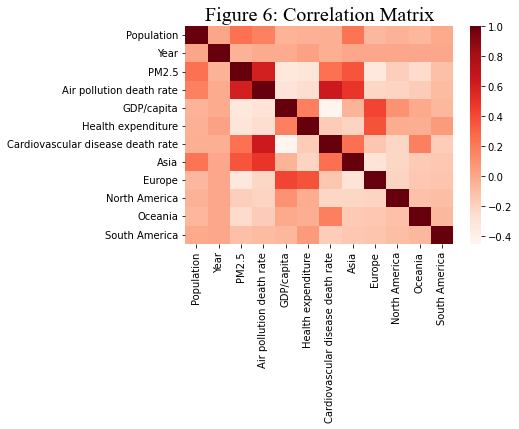

In [30]:
#Creating the correlation matrix:
df_global_clean1 = df_global_clean.rename(columns={'Continent_Asia':'Asia','Continent_Europe': 'Europe', 'Continent_North America': 'North America', 'Continent_Oceania':'Oceania', 'Continent_South America':'South America'})

#Plotting:
corrMatrix = df_global_clean1.corr()
sns.heatmap(corrMatrix, cmap="Reds")
plt.title('Figure 6: Correlation Matrix',**csfont, size=20)
plt.show()

**Splitting our data into test, train and validation data:**

We start out by splitting the data into a test, train and validation set. The validation set will be the data from year 2017, which is the year where we want to predict the death rate. The data from the remaining years are further splitted into training and training data (70/30%).

In [31]:
#Retrieving observations from 2017 for validation:
val_df = df_global_clean[df_global_clean['Year']==2017]
remaining_obs = df_global_clean[df_global_clean['Year']!=2017]

y_val = val_df["Air pollution death rate"]
y = remaining_obs["Air pollution death rate"]

x_val = val_df.drop(['Code','Country Name','Country Code','Air pollution death rate'], axis=1)
x = remaining_obs.drop(['Code','Country Name','Country Code','Air pollution death rate'], axis=1)

In [32]:
#Splitting into train and test data 70/30:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=0)

**Fitting the model:**

We are using a RandomForestRegressor to predict air pollution death rates. We are using a regressor rather than a classifier as our target variable is continuous, and Random Forest over Decision trees as this type of algorithm is significantly more powerfull and less prone to overfitting (Grus ch. 17, 2015). 

In [33]:
# Instantiate model
rf = RandomForestRegressor(random_state = 0)

# Train the model on training data
rf.fit(x_train, y_train);

#Predicting:
y_pred = rf.predict(x_test)

##### Evaluating the performance of the initial model:
As we are working with a regression problem instead of a classification problem the model will be evaluated based on the mean squared error (MSE) which represents the average squared difference between the predicted values and the actual values (Hiregoudar 2020).

In [34]:
from sklearn.metrics import mean_squared_error
import math

#Calculating the MSE:
print('The MSE of our baseline model is', math.sqrt(mean_squared_error(y_test, y_pred)))

The MSE of our baseline model is 7.5594414535676195


**Tuning hyperparameters:**

We chose to perform a 5-fold cross-validation to find the optimal hyperparameters for the model for our model, with the aim of improving our baseline model. Through this approach we are, to a higher extend, avoiding overfitting. We use RandomizedSearchCV from Scikit-Learn to define a grid of relevalt parameters, and use this grid in the cross-validation of the 5 different folds (Koehrsen 2018).

In [36]:
#Defining parameters:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Creating the grid with all the parameters:
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [37]:
#Initializing a kfold with 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=8)

#We are now performing the search and fitting it:
rf_kf = RandomizedSearchCV(estimator = rf, param_distributions = grid, cv = kfold, random_state=0)

# Fit the random search model
rf_kf.fit(x_train, y_train)

#Finding the best parameters:
rf_kf.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

**Training the model based on best parameters and predicting the death rate in 2017 based on the past:**

We are now using the best possible model to predict the death rate in 2017 using our validation data.

In [38]:
#Defining the best model:
best_model = rf_kf.best_estimator_

#validation from the best model:
y_val_best = best_model.predict(x_val)

print('The MSE of the tuned model is', math.sqrt(mean_squared_error(y_val, y_val_best)))

The MSE of the tuned model is 9.276057882339527


#### Results:
Based on the predicted values, it is now possible to plot the results to gain an understanding of how the model predicts. Based on the scatterplot presented in Figure B it is evident that we based on the random forest regressor are able to obtain quite accurate predictions of number of pollution deaths in 2017. The plot is showing a clear linear relation with no significant outliers, thereby indicating that our model is performing relatively well. 

Figure A reports the feature importance of the features included in our final regressor. The feature importances make it possible to determine what contributed to the predictions of the models, and if some of the features, to a higher extend, were included as noise. Based on the plot it is evident that the attribute *Cardiovascular disease death rate* is weighted the highest. However, many air-pollution deaths are, according to WHO attributable to cardiovascular disease, which might explain the high importance of this feature (Kim et. al 2020). We further observe that features such as $PM_{2.5}$, Asia and *GDP* are  significant predictors of death rates.

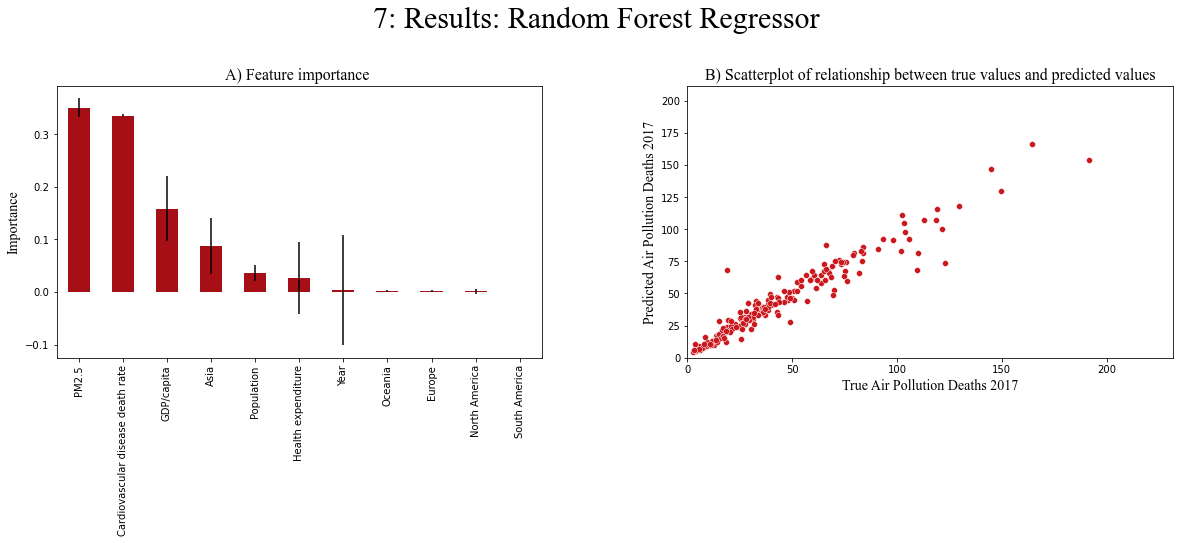

In [39]:
# Initiating subplots
colors= ["#fff5f0","#fee0d2","#fcbba1","#fc9272","#fb6a4a","#ef3b2c","#cb181d","#a50f15","#67000d"]

fig, axes = plt.subplots(1, 2, figsize=(20,5))
x = x.rename(columns={'Continent_Asia':'Asia','Continent_Europe': 'Europe', 'Continent_North America': 'North America', 'Continent_Oceania':'Oceania', 'Continent_South America':'South America'})

#Visualization of feature importance:
importances = best_model.feature_importances_
std = np.std([best_model.feature_importances_ for best_model in best_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x.columns)
forest_importances = forest_importances.sort_values(ascending=False)

forest_importances.plot.bar(yerr=std, ax=axes[0], color = colors[7])
axes[0].set_title("A) Feature importance ",fontsize=16,**csfont)
axes[0].set_ylabel("Importance",fontsize=14,**csfont)

#Plotting the reltionship between y_validation and the predicted y:
sns.scatterplot(x=y_val, y=y_val_best, ax=axes[1], color=colors[6])
plt.ylabel("Predicted Air Pollution Deaths 2017",**csfont, size=14)
plt.xlabel("True Air Pollution Deaths 2017",**csfont, size=14)
plt.xlim([0,y_val.max()+40])
plt.ylim([0,y_val.max()+20])
plt.title('B) Scatterplot of relationship between true values and predicted values',**csfont,fontsize=16)

#Visualizing subplots
fig.suptitle('7: Results: Random Forest Regressor',y=1.1,fontsize=30,**csfont)
plt.subplots_adjust(wspace=0.30, hspace=0.1)
plt.show()

### 2.6 Conclusion: Global patterns
<a name="conclusionglobal"></a>

Based on the first part of the project it is evident that countries with lower GDP are experiencing the biggest burden of polluted air. These countries are most often placed in either Africa or Asia, and are furthermore often the ones suffering from the highest death rates related to air pollution. The results are, thereby indicating clear signs of environmental inequality on a global scale. 

## 3. Pollution in Denmark
<a name="denmark"></a>

**OBS: As the pollution data used in this part of the project is confidential, it will not be possible to run the following part of the notebook. All visualizations nevertheless shown in the notebook and on the website** 

In this section of the report we are zooming in on Denmark to investigate possible inequalities in a country with with high GDP and low concentrations of air pollution. Through the first part of the assignment it became evident that countries with lower GDP experience higher death rates and higher concentrations of pollution than more developed countries. The same tendencies are found in the excisting literature, indicating that individuals with lower socioeconomic background are disproportionally affected by air pollution. Despite Denmark having low concentrations of air pollution, statistics still indicate that the death of 3.500 Danish citizens are caused by bad air every year. However, there is a lack of research into who the affected individuals are, and if there are geographical differences in the exposure, which is our main motivation for conducting this analysis.

### 3.1 Data
<a name="denmarkdata"></a>

Through this part of the analysis we are using data from three different sources to shed light on possible inequalitites related to bad air. The pollution data used in the analysis is collected in 2015, and we are therefore also retrieving social data from this year.

**Luften på din vej**

The pollution data is collected as a part of the research project *Luften på din vej*. The main goal of the original dataset is to raise awareness about air quality in a Danish context, and make the information available for the general public. The dataset contains three different types of pollutants ($NO_{2}$, $PM_{2.5}$ and $PM_{10}$), and the concentrations have been modelled for 2.4 milion adresses in Denmark. We are thus working with a dataset covering all parts of Denmark, leading to minimal bias related to activity (Wan & Nakayama, 2012). We got access to the dataset in relation to another project, and we are thereby not allowed to share the data further, or use it in its original form where it is mapped into 8043 smaller and more homogeneous Danish areas. It would furthermore, be impossible to gain access to social data (registerdata) on such a granular level. Thus, the data is mapped into Danish muncipalities in order to combine and compare it with data retrieved from Statistics Denmark. 

**Statistics Denmark**

We are further retrieving multiple datasets from Statistics Denmark (Statistikbanken) and combining them based on muncipalities. The datasets cover aspects such as income, health expenses and the predicted life expectancy for children born in 2015.

**Shapefiles from DAWA**

Finally, we are using geographical shapefiles from DAWA to plot the Danish data. We are mapping our data into muncipalities (98) instead of regions (5) as this approach allows us to ivestigate differences on a more granular level. The shapefiles are retrieved through DAGI's (Danmarks Administrative Geografiske Inddeling) API. 

In [2]:
#Importing modules:
import pandas as pd
import numpy as np
from pyproj import CRS
import geopandas as gpd
from pyproj import Proj, transform
import matplotlib.pyplot as plt
from scipy import stats
import astropy.stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import folium

# Importing relevant modules for making bokeh-plots 
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, reset_output
from bokeh.models import  ColumnDataSource, Legend
from bokeh.models import HoverTool
from bokeh.models.widgets import Tabs, Panel
from bokeh.io import curdoc
from bokeh.layouts import layout
from bokeh.models import LinearInterpolator
from bokeh.plotting import figure, output_file, save
from bokeh.layouts import column
from bokeh.models import Div
output_notebook()

Loading BokehJS ...

### 3.2: Data mining and preprocessing
<a name="denmarkpre"></a>
As an initial stage of the analysis we are mapping the smaller areas into the Danish muncipalities. As shown below, each area is represented by a ploygon with geographical information in the form of epsg 25832 (UTM zone 32N). However, the data retrieved through DAWA is in the format of epsg 4326 (standard coordinate frame for the Earth), and it is therefore necessary to convert our data to this format before mapping the smaller areas and muncipalities together.

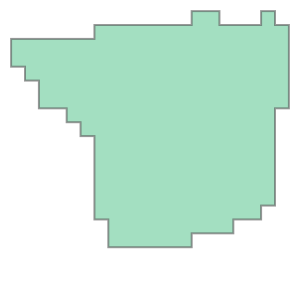

In [3]:
#Importing the shapefile representing the 8043 areas:
areas_ = gpd.read_file("mergedarea.dbf")

# Define crs
areas_.crs = CRS.from_epsg(25832)

#Visualizing the initial format of the geo-data:
areas_.geometry[0]

<img src= "https://raw.githubusercontent.com/KvantropologSofie/socialdata2022.io/main/area.png" width="300"/>

For each area in our original dataset we are finding the centroid. These centroids will afterwards be used to map each of the initial areas into muncipalities based on the nearest neighbors. 

In [4]:
#Finding the centroid for each goemetry:
areas_['centroid'] = areas_['geometry'].centroid

We are now transforming each centroid to the desired format by using PYPROJ (a cartographic projections and coordinate transformations library).

In [5]:
#Defining function to transform the epsg of our data:
def mytransform(point):
    inProj = Proj('epsg:25832') #input proj
    outProj = Proj('epsg:4326') #output proj
    x1, y1 = point.x, point.y
    x2, y2 = transform(inProj,outProj,x1,y1)
    return [y2, x2] #returning lan and lon

#Applying the function to the centroids to get latitude and longitude:
areas_['lat_lon'] = areas_['centroid'].apply(mytransform)

Retrieving shapefiles from DAWA and turning the relevant information into a dataframe:

In [10]:
import requests
response = requests.get("https://api.dataforsyningen.dk/kommuner")
shapefile = response.json()

In [12]:
#Importing the shapefile from dawa:
#Creating empty lists to save the information:
names = []
coordinates = []
region = []
bb = []
kod = []

#looping through the shapefile to save the information as a dataframe:
for item in shapefile:
    i = item['navn']
    c = item['visueltcenter']
    r = item['region']['navn']
    b = item['bbox']
    k = item['kode']
    
    #appending the info to the empty lists:
    names.append(i)
    coordinates.append(c)
    region.append(r)
    bb.append(b)
    kod.append(k)
    
    #Creating final dataframe containing the information of interest:
    df = pd.DataFrame(list(zip(names, coordinates, region, bb, kod)),
               columns =['Name', 'Coordinates', 'Region', 'B', 'kode'])

We are now mapping each of the smaller areas in our original dataset into the muncipalities found through DAWA. Each small area is mapped into the closest muncipality (the nearest neighbor) based on the centroid (the middle of the polygon). 

In [13]:
#Find closest municipality
X = []
Y = []

for j, reg in enumerate(areas_.lat_lon): #Looping through the converted centroids.
    dist = [] #Empty list
    for i, mun in enumerate(df.Coordinates): #Looping through each muncipalities coordinates:
        #appending the distance between lat and lon to the empty list:
        dist.append(np.linalg.norm([mun[0]-reg[0], mun[0]-reg[0]])) 
    dists = np.array(dist) 
    idx = dists.argmin()
    #X[idx].append(j)
    X.append(df.iloc[idx].Name)
    Y.append(df.iloc[idx].kode)
    matches = pd.DataFrame(zip(X,Y), columns =['City', 'Kode'])

#creating a final column in the dataset corresponding to the respective area:
matches = matches.reset_index()
matches['area'] = matches['index'] + 1

The pollution data is now merged onto the new dataset by maching based on areas:

In [15]:
#Reading the data
pollution = pd.read_csv('pollution.csv')
#Merging based on areas:
pollution = pollution.merge(matches, on='area')
pollution = pollution[['City', 'Kode','area', 'MEAN_NO2Gade', 'MEAN_PM25Gade', 'MEAN_PM10Gade']]
pollution.head(2)

,City,Kode,area,MEAN_NO2Gade,MEAN_PM25Gade,MEAN_PM10Gade
0,Nyborg,0450,1,7.652307,10.539932,14.297604
1,Langeland,0482,2,7.765130,10.593023,14.325582


Looking into how many areas we have in each of the different muncipalities:

In [16]:
agg = pollution.groupby('City').agg({'area': 'count', 'MEAN_PM25Gade':'var'}).sort_values(ascending=False, by='area').reset_index()

In [17]:
print('The muncipalities with fewest areas is:',agg['City'].iloc[-1], 'with',agg['area'].iloc[-1], 'areas.')
print('The muncipalities with most areas is:', agg['City'].iloc[0], 'with',agg['area'].iloc[0], 'areas.')

The muncipalities with fewest areas is: Ballerup with 2 areas.
The muncipalities with most areas is: Nordfyns with 280 areas.


It is evident that there are quite big differences in the number of areas per muncipality. We therefore decided to look further into this, by plotting a histogram, and thereby getting a overview of the distribution of areas in each muncipality. As in Assignment 1, we choose to define the bin with using Scott's rule (Janert, 2010, p. 16). 

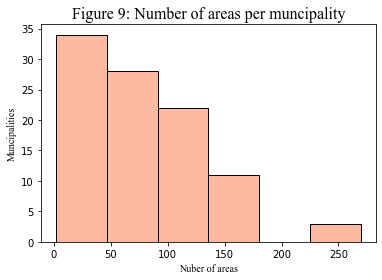

In [20]:
#Finding the right bin width:
scotts = astropy.stats.scott_bin_width(agg['area'])

#Plotting:
plt.hist(agg['area'], color = '#fcbba1', edgecolor='black', bins=np.arange(min(agg['area']), max(agg['area']), scotts))
plt.title('Figure 9: Number of areas per muncipality', size=16, **csfont)
plt.xlabel("Nuber of areas", **csfont)
plt.ylabel("Muncipalities", **csfont)
plt.show()

Based on the histogram it is evident that most of the muncipalities have less than 50 areas, while only few are having more than 200. Under other circumstances it would make sense to look further into the variance in concentrations of air pollutants to investigate possible bias related to issues such as a lack of sensors in specific areas. Nevertheless, as the smaller areas used in this project are already aggregated based on street level (where we have the concentrations for each street in Denmark), we find it reasonable to aggregate the smaller areas into the muncipalities, in order to be able to compare the concentrations with our social/economic data.

In [27]:
#Grouping by muncipality and taking the mean of the airpollutants:
agg_pollution = pollution.groupby(['City', 'Kode']).agg({'MEAN_NO2Gade': 'mean', 'MEAN_PM25Gade': 'mean','MEAN_PM10Gade': 'mean'}).reset_index()

**Adding social data from Statistics Denmark**

We are further adding data from statistics Denmark to the dataframe. The data is merged based on muncipalities. As described earlier, we are interested in data regarding income, health-expenses and life-expectancy of children born in 2015. 

In [28]:
#average income:
income = pd.read_excel('indkomst_dk_statistik.xlsx')  
income = income.rename(columns={"Unnamed: 0": "munci", "2015":"Income"})
income = income.drop(columns={"2016","2017","2018","2019","2020"})

#health expenses:
health_expenses = pd.read_excel('sundhedsudgifter.xlsx') 

#Merging:
data_frames = [health_expenses, income]

import functools as ft
df_dk = ft.reduce(lambda left, right: pd.merge(left, right, on='munci'), data_frames)

#Life expectancy for kids born now:
life_expectancy = pd.read_excel('life_expect.xlsx') 
life_expectancy = life_expectancy.rename(columns={"All Denmark": "munci", 80.9:"Life expectancy kids"})

df_dk = df_dk.merge(life_expectancy, on='munci', how='left')

#Merging social factors and pollutiondata:
df_dk = df_dk.merge(agg_pollution, left_on='munci', right_on ='City', how='right')

**Adding geodata to the frame:**

As the last part of the preprocessing we are adding additional geo-data to the dataframe such as the coordinates of each muncipality and the corresponding region. We are again using the data from DAWA, but this time by importing it as a geopandas dataframe.

In [29]:
#Importing the geo-locations as a geopandas df:
locations_df = gpd.read_file("https://api.dataforsyningen.dk/kommuner?format=geojson")
locations_df = locations_df[['regionskode', 'kode', 'geometry', 'regionsnavn', 'navn']]
df_final = locations_df.merge(df_dk, right_on ='munci', left_on ='navn', how='right')
df_final = df_final[['Kode','regionskode', 'geometry', 'regionsnavn', 'navn', 'Sundhedsudgifter pr indbygger', 'Income', 'Life expectancy kids', 'MEAN_NO2Gade', 'MEAN_PM25Gade', 'MEAN_PM10Gade']]

### 3.3 Basic stats:
<a name="statsdk"></a>

After the preprocessing steps we end up with our final dataset containing 10 different columns and 98 rows (corresponding to 98 muncipalities spread across 5 different regions). Figure 10 represents boxplots showing the distribution of our final features. From the plot it is evident, that NO2 is the type of pollution with the biggest variance ranging from 4 to 20, with a mean of approximately 10. It is further evident, that $PM_{10}$ and $PM_{2.5}$ are having lower variance with a more normal distribution. Despite these findings we will mainly focus on $PM_{2.5}$ in the further analysis, as this type of pollution has health impacts even at very low concentrations, and is ranked as the top 5th cause of death globally. 

When looking into the variables retrieved from Statistics Denmark, we are likewise finding big differences in the variance of the features. Especially in income, where some muncipalities are having an average income of 600.000, while others are less than half. The same tendencies are found in both predicted life expectancy, but also in health expenses where there are significant differences in the minimum and maximum values. The boxplots are thus indicating clear differences in all features for the different muncipalities. In order to investigate these differences further, we are going to map the geographical patterns.

In [31]:
df_final = df_final.rename(columns={"MEAN_NO2Gade": "NO2", "MEAN_PM25Gade":"PM2.5", "MEAN_PM10Gade":"PM10", 'Sundhedsudgifter pr indbygger':'Health expenses','Life expectancy kids':'Life expectancy'})

vars = ['Health expenses', 'Income', 'Life expectancy','NO2', 'PM2.5', 'PM10']
fig = make_subplots(rows=1, cols=len(vars))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=df_final[var],
        name=var),
        row=1, col=i+1
    )
fig.update_layout(title_text="Figure 10: Boxplots over the Danish attributes", colorway =["#fcbba1","#fc9272","#fb6a4a","#ef3b2c","#cb181d","#a50f15","#67000d"] )

fig.update_layout(
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    plot_bgcolor="#f5f5f5")

fig.update_traces(boxpoints='all', jitter=.01)

# # set output to static HTML file
#Saving HTML code to put on the website
plotly.offline.plot(fig, auto_open=False,filename='boxplotsnew.html', validate=True)

'boxplotsnew.html'

### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [1]:
from IPython.display import IFrame

# Displaying air pollution in Denmark
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/8da5418d1fe64920d241ea779d64130ed9f172f2/boxplotdk%20(1).html", width=1000, height=750)

### 3.4 Data Analysis:
<a name="analysisdk"></a>

**3.4.1: Mapping**

The mapping of the annual concentrations indicates that Zealand, and especially the Capital Region of Denmark and Region Zealand are exposed to the highest annual concentrations of $PM_{2.5}$ and $NO_{2}$, while high concentrations of $PM_{10}$ are more prevalent in the western part of Denmark. When looking into the maps reporting the data from Statistics Denmark, we observe patterns of the Capital Region of Denmark a having higher annual income that the remaining regions, while we at the same time observe higher annual income in the areas surrounding bigger Danish cities such as Århus. At the same time, it is also evident that municipalities in southern Denmark, such as Lolland and Langeland are having significantly lower annual incomes. When looking into the average health expenses spent on each citizen, it is further clear, that the municipalities with lower income have higher expenses related to healthcare. Through the final layer in the mapping of the data from Statistics Denmark we observe that the municipalities characterized by lower incomes and higher health expenditure, are also the municipalities where kids born today can expect to have shorter lives. Thus, these results are indicating that both high-income and low-income municipalities on Zealand are exposed to high annual concentrations of $PM_{2.5}$. We will investigate these patterns further by looking into possible realtions between the different features through scatterplots.

In [33]:
#Retrieving the geodata needed for the plots:
#response = requests.get("https://api.dataforsyningen.dk/kommuner?format=geojson")
#df_dk = response.json()
#df_final = df_final[df_final['navn'].notna()]

In [34]:
response = requests.get("https://api.dataforsyningen.dk/kommuner?format=geojson")
df_dk_ = response.json()

As our geojson file is extremely large we have to reduce its size before using it in our maps:

In [36]:
import visvalingamwyatt as vw

for i, geometry in enumerate(df_dk_["features"]):
    # returns a copy of the geometry, simplified (keeping 20% of points)
    df_dk_["features"][i]["geometry"] = vw.simplify_geometry(df_dk_["features"][i]["geometry"], ratio=0.20)

In [230]:
df_dk = df_dk_.copy()

**Pollution with $PM_{2.5}$, $PM_{10}$ and $NO{2}$ in a Danish context**

In [261]:
# Create a Map instance
from folium import plugins

#align="center" 
loc = 'Annual concentrations of air pollution (2015)'

title_html = '''
             <h3 style="font-size:16px" face="Times New Roman" ><b>{}</b></h3>
             '''.format(loc)   

m = folium.Map(location=[56.26392, 9.501785], tiles = 'cartodbpositron', zoom_start=7, control_scale=True, overlay=True)
m.get_root().html.add_child(folium.Element(title_html))


# Plot a choropleth map
# Notice: 'geoid' column that we created earlier needs to be assigned always as the first column

choropleth = folium.Choropleth(
    geo_data=df_dk,
    data=df_final,
    name = 'Particulate matter (PM2,5)',
    columns=['Kode', 'PM2.5'],
    key_on='feature.properties.kode',
    fill_color="Reds",
    fill_opacity=2,
    overlay=True,
    highlight=True,
    line_opacity=0.3, legend_name= 'PM2.5').add_to(m)

choropleth1 = folium.Choropleth(
    geo_data=df_dk,
    name='Nitrogen dioxide (NO2)',
    data=df_final,
    columns=['Kode', 'NO2'],
    key_on='feature.properties.kode',
    fill_color="Reds",
    fill_opacity=2,
    line_opacity=0.3,
    overlay=True,
    #threshold_scale=[0,10,11,12,13,14],#
    legend_name= 'NO2').add_to(m)

choropleth2 = folium.Choropleth(
    geo_data=df_dk,
    data=df_final,
    name = 'particulate matter (PM10)',
    columns=['Kode', 'PM10'],
    key_on='feature.properties.kode',
    fill_color="Reds",
    fill_opacity=2,
    overlay=True,
    line_opacity=0.3,
    #threshold_scale=[0,10,11,12,13,14],#
    legend_name= 'PM10').add_to(m)

#folium.TileLayer('cartodbpositron',overlay=True,name="View in Light Mode").add_to(m)
folium.LayerControl(collapsed=False).add_to(m)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['navn', 'regionsnavn'], labels=True))
choropleth1.geojson.add_child(folium.features.GeoJsonTooltip(['navn', 'regionsnavn'], labels=True))
choropleth2.geojson.add_child(folium.features.GeoJsonTooltip(['navn', 'regionsnavn'], labels=True))

m
m.save('pollution_map_dk_final.html', include_plotlyjs="cdn")


### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [3]:
# Displaying air pollution in Denmark
from IPython.display import IFrame
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/22fd7f086c55cf371a6be9dd7fc9968a5bdb0a16/pollution_map_dk_final.html?", width=1000, height=750)

**Mapping of income, health expenses and life expectancy**

In [262]:
loc = 'Income, health expenses and life expectancy (2015)'

title_html = '''
             <h3 align="center" style="font-size:16px" face="Times New Roman" ><b>{}</b></h3>
             '''.format(loc)   

m = folium.Map(location=[56.26392, 9.501785], tiles = 'cartodbpositron', zoom_start=7, control_scale=True)
m.get_root().html.add_child(folium.Element(title_html))


# Plot a choropleth map
# Notice: 'geoid' column that we created earlier needs to be assigned always as the first column

choropleth = folium.Choropleth(
    geo_data=df_dk,
    data=df_final,
    name = 'Income',
    columns=['Kode', 'Income'],
    #threshold_scale=[200000, 250000, 270000, 300000,350000,400000,500000,600000,700000],
    key_on='feature.properties.kode',
    fill_color="Reds",
    fill_opacity=2,
    overlay=True,
    highlight=True,
    line_opacity=0.3, legend_name= 'Income').add_to(m)

choropleth1 = folium.Choropleth(
    geo_data=df_dk,
    name='Health expenses per citizen',
    data=df_final,
    columns=['Kode', 'Health expenses'],
    key_on='feature.properties.kode',
    fill_color="Reds",
    fill_opacity=2,
    line_opacity=0.3,
    overlay=True,
    #threshold_scale=[0,10,11,12,13,14],#
    legend_name= 'Health expenses').add_to(m)

choropleth2 = folium.Choropleth(
    geo_data=df_dk,
    data=df_final,
    name = 'Life expectancy for children born in 2015',
    columns=['Kode', 'Life expectancy'],
    key_on='feature.properties.kode',
    fill_color="Reds",
    fill_opacity=2,
    overlay=True,
    line_opacity=0.3,
    #threshold_scale=[0,10,11,12,13,14],#
    legend_name= 'Life expectancy').add_to(m)

#folium.TileLayer('cartodbpositron',overlay=True,name="View in Light Mode").add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

#Displaying regions and 
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['navn', 'regionsnavn'], labels=True))
choropleth1.geojson.add_child(folium.features.GeoJsonTooltip(['navn', 'regionsnavn'], labels=True))
choropleth2.geojson.add_child(folium.features.GeoJsonTooltip(['navn', 'regionsnavn'], labels=True))

m
m.save('social_map_final.html', include_plotlyjs="cdn")

Code displaying the map without running the code:

### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [5]:
from IPython.display import IFrame
# Displaying air social factors in Denmark
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/22fd7f086c55cf371a6be9dd7fc9968a5bdb0a16/social_map_final.html?raw=true", width=1000, height=750)

**3.4.2: Scatterblots**

In the folowing section we are investigating the relation between the attributes through scatterplots.

In [98]:
scatter = df_final[['navn', 'Income', 'regionsnavn', 'PM2.5', 'Life expectancy', 'NO2']]
scatter = scatter.rename(columns={"PM2.5":"PM", "Life expectancy":"LE"})
regions=list(scatter.regionsnavn.unique())
regions

'''Creating bokeh scatterplot'''
#output_file("toolbar.html")

# Defining a colormap of 6 blue colors according to GDP-categories
cmap=["#fcbba1","#fc9272","#fb6a4a","#ef3b2c","#cb181d","#a50f15","#67000d"]
index_cmap = factor_cmap('regionsnavn', palette=cmap, 
                         factors=regions)

p1 = figure(plot_width=600, plot_height=400, title = "A) Relationship between income and PM2.5",
           toolbar_location='below',tools=['hover', 'pan','zoom_in'],tooltips=[('Kommune: ',"@navn"),
            ("PM2.5: ","@PM"), ("Income: ","@Income"), ('Region',"@regionsnavn")])

# Adjusting title size and moving legend outside of the plot 
p1.title.text_font_size = '12pt'
p1.add_layout(Legend(label_text_font_size = '8pt'), 'right')
#p.legend.label_text_font_size = '20pt'
p1.legend.click_policy="hide"

p1.scatter('PM','Income',source=scatter,fill_alpha=0.6,line_color=index_cmap, 
          fill_color=index_cmap,size=7, legend_field='regionsnavn')
p1.xaxis.axis_label = 'Particulate matter (PM2.5)'
p1.yaxis.axis_label = 'Income'
p1.xaxis.axis_label_text_font = 'Times New Roman'
p1.yaxis.axis_label_text_font = 'Times New Roman'
p1.title.text_font = "times new roman"

#Second plot:
index_cmap = factor_cmap('regionsnavn', palette=cmap, 
                         factors=regions)
p2 = figure(plot_width=600, plot_height=400, title = "B) Relationship between life expectancy and PM2.5",
           toolbar_location='below',tools=['hover', 'pan','zoom_in'],tooltips=[('Kommune: ',"@navn"),
            ("PM2.5: ","@PM"), ("Life expectancy: ","@LE"), ('Region',"@regionsnavn")])

# Adjusting title size and moving legend outside of the plot 
p2.title.text_font_size = '12pt'
p2.add_layout(Legend(label_text_font_size = '8pt'), 'right')
#p.legend.label_text_font_size = '20pt'
p2.legend.click_policy="hide"

p2.scatter('PM','LE',source=scatter,fill_alpha=0.6,line_color=index_cmap, 
          fill_color=index_cmap,size=7, legend_field='regionsnavn')
p2.xaxis.axis_label = 'Particulate matter (PM2.5)'
p2.yaxis.axis_label = 'Life expectancy'
p2.xaxis.axis_label_text_font = 'Times New Roman'
p2.yaxis.axis_label_text_font = 'Times New Roman'
p2.title.text_font = "times new roman"

#Third plot
index_cmap = factor_cmap('regionsnavn', palette=cmap, 
                         factors=regions)
p3 = figure(plot_width=600, plot_height=400, title = "C) Relationship between life expectancy and income",
           toolbar_location='below',tools=['hover', 'pan','zoom_in'],tooltips=[('Kommune: ',"@navn"),
            ("Income: ","@Income"), ("Life expectancy: ","@LE"), ('Region',"@regionsnavn")])

# Adjusting title size and moving legend outside of the plot 
p3.title.text_font_size = '12pt'
p3.add_layout(Legend(label_text_font_size = '8pt'), 'right')
#p.legend.label_text_font_size = '20pt'
p3.legend.click_policy="hide"

p3.scatter('LE','Income',source=scatter,fill_alpha=0.6,line_color=index_cmap, 
          fill_color=index_cmap,legend_field='regionsnavn',size=7)
p3.xaxis.axis_label = 'Life expectancy'
p3.yaxis.axis_label = 'Income'
p3.legend.label_text_font = "times"
p3.xaxis.axis_label_text_font = 'Times New Roman'
p3.yaxis.axis_label_text_font = 'Times New Roman'
p3.title.text_font = "times new roman"

plots1 = column(p1, p2, p3)
#show(column(Div(align="center", text="<h2> Figure 13: Scatterplots reporting the relationship between income, life expectancy and pollution </hl>"), plots))

# # set output to static HTML file
output_file(filename="scatterplots_df1.html", title="Static HTML file")
save(plots1)

'/Users/miaannjorgensen/Desktop/Visualisation/scatterplots_df1.html'

### **RUN THE CELL BELOW TO SEE VISUALIZATION**

In [4]:
from IPython.display import IFrame

# Displaying air pollution in Denmark
IFrame(src="https://rawcdn.githack.com/KvantropologSofie/socialdata2022.io/e277416e7c642c7226aa1129fd0b718e5f6d7af9/scatterplots_df1.html", width=1000, height=750)

We are lastly going to investigate potential relationships between exposure to $PM_{2.5}$, income and life expextancy through the scatterplots presented above. Based on scatterplot A, we are finding evidence of the muncipalities in Zealand being exposed to higher concentrations of PM2.5. It is further evident that these mucipalities are having a big variance in annual income, ranging from Bornholm with an average income of 262.203, to Gentofte with an average annual income of 611.952. Thus, these results indicate, that individuals with different social background are exposed to the same high consentrations of air pollution. To get a further understanding of the potential consequenses of this, we decided to plot the relationship between exposure to air pollutants and life expectancy as reported in B. Based on the plot it is evident that there are no clear relationship between exposure to $PM_{2.5}$ and life expectancy, where muncipalities with both the lowest (Lolland) and highest (Rudersdal and Gentofe) are experiencing the same concentrations of pollution. When looking into the relationship between life expectancy and income, we are, nevertheless, observing a clear picture of muncipalities with higer annual incomes also having a higher life expectancy. 

Based on the scatterplots it is thereby apparent that muncipalities with high concentrations of pollution, is often located in Region Zealand or the Capital Region of Denmark, while muncipalities located in the remaining parts of Denmark are experiencing lower concentrations of $PM_{2.5}$. It is furthermore also evident that the muncipalities experiencing the higest concentrations of pollutions are populated with individuals from significantly different economic positions. The results are thereby not showing signs of environmental inequality, but rather that individuals with higher economic capital can expect to live longer lifes.

### 3.4 Conclusion - Denmark:
<a name="conclusiondk"></a>

Throughout this part of the project we have zoomed in on Denmark to investigate whether environmental inequality also exsists in a Developed country with relatively low exposure to pollution. Based on our visualizations it is evident, that Zealand is exposed to the higest concentrations of pollution, while also having the biggest income inequality. Thus, our project indicates that individuals with different economic capital are exposed to the same high concentrations of pollutions, but also that different groups in society may be affected differently by the negative consequenses of the bad air. Kids born in Gentofte, which is the muncipalities with the highest annual income, but also concentrations of $PM_{2.5}$ can expect to live significantly longer lives than kids born in Lolland who are experiencing simmilar concentrations of $PM_{2.5}$. 

## 4. Genre:
<a name="genre"></a>

According to Segel and Heer, the organization of design space contains three divisions of features: genre, visual narrative tactics, and narrative structure tactics. 

For the story genre we used part magazine style and part annotated graph. Annotated chart is an obvious choice to highlight the visualizations we wish to present and also to allow for further interactivity. However as Segel and Heer mention, interactive graphs typically under-utilize common narrative techniques such as repetition of key points, introductory texts, and final summaries and syntheses. In order to emphasize key observations from the data, we will also incorporate part of a magazine style. 

For visual narrative tactics we consider visual structuring, highlighting, and transition guide. Our visual structuring is primarily in the form of having a consistent visual platform. The other visual narrative tactics are more applicable to slide show or film genres and not as much the magazine styles. Given our chosen genre, we focus less on visual narrative tactics and more on narrative structure.

We apply many of the narrative structure tactics as these are quite important for our genres. The ordering is more of a user-directed path. While the menu on the left of the website hints at a direction, and therefore is not random, it is ultimately up to the user to click and choose their own path. We also did this to allow for a more clear divide between the key takeaways of the different parts of our story. We choose to employ interactivity with the graphs more than with the website itself. Since our focus is the data we wish to visualize, we bring the user closer to the data by allowing them to interact with it. And lastly, bringing in key parts of the magazine style, our messaging will be very thorough and consist of captions, headlines, comment repetition, introductory texts, summary conclusion, etc.  


## 5. Vizualisations:
<a name="visualisations"></a>

We have chosen a wide range of different visualizations in our project. In this section we will briefly describe the visualizations included in the website, and why we deem them relevant for the story we want to tell.

- **Boxplots:** We included boxplots as an initial way to investigate the variability in our features. The boxplots provided us with information of the distribution of the observations, and made it possible to determine whether there were visible outliers in the concentration of air pollution, GDP and income (Janert, P. K. 2010). We decided to add a jitter to our boxplots to detect possible clusters in the data.

- **Maps:** We chose to include mulitple interactive maps to visualize spartial differences in a more intuitive way. Through maps it is possible to highlight trends in pollution and GDP/income, and thereby gain clarity over patterns. The maps further made it possible to visualize changes in concentrations of air pollution over time.

- **Lineplots:** In addition to the map visualizing changes over time, we chose to create a line plot. Through the line plot it is possible to easily compare changes across the different continents, and gain an overall overview of the tendencies.

- **Scatterplots:** We lastly included scatterplots to investigate possible relations between our features (Janert, P. K. 2010). 


## 6. Discussion and conclusion:
<a name="finalcon"></a>
Through this project we have investigated differences in exposure to air pollution globally and nation-wise. In line with the existing research, our results indicate that countries with lower GDP are more affected by bad air quality. High concentrations of $PM_{2.5}$ are especially prevalent across Asia and Africa, where many countries also are suffering from high death rates caused by pollution. The first part of the project thus indicates that there are clear signs of environmental inequality related to air pollution globally, and that the negative consequences of air-pollution are affecting countries with lower GDP to a higher extend than countries with higher GDP. 
 
We further zoomed into Denmark to investigate a country on an individual and more granular level. Based on the global part of our report, Denmark stood out as a country exposed to low concentrations of PM2.5, while at the same time having a high GDP. However, when looking into the Danish municipalities we found significant differences in both income and exposure to air pollutants. Through the Danish part of the project, it was not possible to find clear signs of environmental inequality, as both municipalities with higher and lower income are exposed to the same high concentrations of pollution. However, we found that Zealand in general experience the highest concentrations of air pollution. The existing research further indicates, that socially and economically disadvantaged individuals are more susceptible to the negative health effects of air pollution (Williams et. al (2018). We find the same patterns globally, but also when zooming in on Denmark, where children born in Gentofte can expect to live significantly longer than children born in Lolland despite experiencing the same concentrations of air pollution throughout life. However, as life expectancy is simply an estimation, future studies should compare pollution to actual health indicators from a Danish context. Our study thus indicates that it is essential to assess each respective country on an individual and more granular level in order to capture variations within. Even within a highly developed nation as Denmark we find significant differences in both income, life expectancy and exposure to different types on pollutants. Therefore, even bigger differences are likely to be found in countries such as Qatar with high GDP, high income-inequalities and high concentrations of air pollution when looking into nation-wide patterns.

Even though our patterns appear quite clear, we should not blindly trust the data. Through our visualizations, several biases and errors became visible, such as the unrealistic increase in pollution in Madagascar from 2016 to 2017. In line with the arguments of Janert (2010), these data errors would most likely have gone unnoticed without the different visualizations. We are further aware that the data, especially from the global part of the project, might be subject to biased related to how it is measured. Countries with fewer resources might not have the capacity to produce accurate estimates of neither pollution deaths nor concentrations. We are furthermore not aware of the number of sensors used to estimate the concentrations for each country. Thus the environmental inequality that we found using data might be even larger, but unfortunately, this is difficult for us to account for. 

## 7. Contributions:
<a name="contributions"></a>



*Assignment Contributions*:

Group Members: 
- Sofie Læbo Astrupgaard
- Mia Ann Jørgensen
- Alysha Chamadia 

Contributions
1. [Motivation](#Motivation) - Sofie, Mia, Alysha
2. [Global Patterns](#Global) -Alysha
    1. [Global data](#globaldata) - Sofie
    2. [Preprocessing and data mining](#preprocessing)- Mia 
    3. [Basic stats and exploration of the data](#basicstats) - Sofie 
    4. [Data analysis](#dataanalysis) - Mia
    5. [Prediction of deaths caused by pollution](#prediction) - Alysha 
    6. [Conclusion](#conclusionglobal) - Alysha
3. [Zooming in on Denmark](#denmark)- Mia
    1. [Data used in the Danish part](#denmarkdata) - Sofie
    2. [Preprocessing and data mining](#denmarkpre) - Mia 
    3. [Basic stats - Denmark](#statsdk) - Sofie
    4. [Data analysis](#analysisdk) - Mia
    4. [Conclusion](#conclusiondk) - Sofie 
4. [Genre](#genre)- Alysha
5. [Visualizations](#visualisations) - Alysha
6. [Discussion and Conclusion](#finalcon) - Mia, Sofie 
8. Website - Mia, Sofie

## 8. References:
<a name="references"></a>


- Hiregoudar, S. (2020). Ways to Evaluate Regression Models - Towards Data Science. Medium. https://towardsdatascience.com/ways-to-evaluate-regression-models-77a3ff45ba70
- Koehrsen, W. (2019, December 10). Hyperparameter Tuning the Random Forest in Python - Towards Data Science. Medium. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- Wiliams et. al (2018). Impact of air pollution scenarios on inequalities
- Janert, P. K. (2010). Data Analysis with Open Source Tools: A Hands-On Guide for Programmers and Data Scientists (1st ed.). O’Reilly Media.
- WHO (2021). https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health
- Srinidhi, S. (2020, January 9). Label Encoder vs. One Hot Encoder in Machine Learning. Medium. https://contactsunny.medium.com/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
- Grus, J. (2015). Data Science from Scratch: First Principles with Python (1st ed.). O’Reilly Media.
- Kim et all. (2020). Cumulative Lifetime Burden of Cardiovascular Disease From Early Exposure to Air Pollution. 
- Hank, C., Arnold, M., and Gerber, A. (2021) Introduction to econometrics with R. https://www.econometrics-with-r.org/index.html